In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_text as text
#import tensorflow_models as tfm
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn import metrics as met
from official.nlp import optimization  # to create AdamW optimizer
import graphviz
import pydot
#import shutil
#import os
import json
import GPUtil
import time

C:\Users\Severus\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Severus\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not fi

In [3]:
from sources.Dataset import load_dataset

In [4]:
class CONFIG: 
    EPS = 1e-8 
    EPOCHS = 8 # 3~5
    BATCH_SIZE = 16 # 8, 32
    LEARNING_RATE = 3e-5 # 1e-5
    MAX_LENGTH = 128 # 256
    ENCODER_TYPE = 'bert-large' # large, RoBERTa, DeBERTa
    OPTIMIZER ='adamw'   
    DEVICE_TYPE = "cuda" # Cuda or alternative
    SAVE_MODEL=False
    TASK='RE-classification'
config=CONFIG()

In [5]:
'''def load_dataset(path,classdict={},shuffle=False):
    with open(path,'r',encoding='UTF-8') as f:
        data=[json.loads(line) for line in f]
    sent=[]
    relation=[]
    for d in data:
        token=d['token']
        #for i in range(d['h']['pos'][0],d['h']['pos'][1]):
            #token[i]='[MASK]'
            #token[i]='$'+token[i]
            #pass
        #for i in range(d['t']['pos'][0],d['t']['pos'][1]):
            #token[i]='[MASK]'
            #token[i]='$'+token[i]
            #pass
        token[d['h']['pos'][0]]='['+token[d['h']['pos'][0]]
        token[d['h']['pos'][1]]=token[d['h']['pos'][1]]+']'
        token[d['t']['pos'][0]]='['+token[d['t']['pos'][0]]
        token[d['t']['pos'][1]]=token[d['t']['pos'][1]]+']'
        
        sent.append([' '.join(token)])
        if classdict.get(d['relation'],False)==False:
            classdict.setdefault(d['relation'],len(classdict))
        relation.append(classdict[d['relation']])
    temp=np.zeros(shape=(len(relation),len(classdict)))
    #print(temp.shape)
    #print(classdict)
    for i in range(len(relation)):
        temp[i][relation[i]]=1
    if shuffle:
        data=tf.data.Dataset.from_tensor_slices((sent,temp)).shuffle(5000).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    else:
        data=tf.data.Dataset.from_tensor_slices((sent,temp)).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return data,classdict,sent,relation

test_ds,classdict,testx,testy=load_dataset('semeval_test.txt')
valid_ds,classdict,validx,validy=load_dataset('semeval_val.txt',classdict,shuffle=True)
train_ds,classdict,trainx,trainy=load_dataset('semeval_train.txt',classdict,shuffle=True)'''

"def load_dataset(path,classdict={},shuffle=False):\n    with open(path,'r',encoding='UTF-8') as f:\n        data=[json.loads(line) for line in f]\n    sent=[]\n    relation=[]\n    for d in data:\n        token=d['token']\n        #for i in range(d['h']['pos'][0],d['h']['pos'][1]):\n            #token[i]='[MASK]'\n            #token[i]='$'+token[i]\n            #pass\n        #for i in range(d['t']['pos'][0],d['t']['pos'][1]):\n            #token[i]='[MASK]'\n            #token[i]='$'+token[i]\n            #pass\n        token[d['h']['pos'][0]]='['+token[d['h']['pos'][0]]\n        token[d['h']['pos'][1]]=token[d['h']['pos'][1]]+']'\n        token[d['t']['pos'][0]]='['+token[d['t']['pos'][0]]\n        token[d['t']['pos'][1]]=token[d['t']['pos'][1]]+']'\n        \n        sent.append([' '.join(token)])\n        if classdict.get(d['relation'],False)==False:\n            classdict.setdefault(d['relation'],len(classdict))\n        relation.append(classdict[d['relation']])\n    temp=np.zero

In [6]:
data_path={'train':'semeval_train.txt',
           'test':'semeval_test.txt',
           'valid':'semeval_val.txt'}

In [7]:
train_ds,test_ds,valid_ds,classdict=load_dataset(data_path)
train_ds['data']=train_ds['data'].shuffle(5000).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds['data']=valid_ds['data'].shuffle(5000).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds['data']=test_ds['data'].batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:

def evaluation(y_true,y_pred):
    acc=met.accuracy_score(y_true,y_pred)
    p=met.precision_score(y_true,y_pred,average=None,zero_division=True).tolist()
    r=met.recall_score(y_true,y_pred,average=None).tolist()
    f1=met.f1_score(y_true,y_pred,average=None).tolist()
    weighted_p=met.precision_score(y_true,y_pred,average='weighted',zero_division=True)
    weighted_r=met.recall_score(y_true,y_pred,average='weighted')
    weighted_f1=met.f1_score(y_true,y_pred,average='weighted')
    macro_p=met.precision_score(y_true,y_pred,average='macro',zero_division=True)
    macro_r=met.recall_score(y_true,y_pred,average='macro')
    macro_f1=met.f1_score(y_true,y_pred,average='macro')
    micro_p=met.precision_score(y_true,y_pred,average='micro',zero_division=True)
    micro_r=met.recall_score(y_true,y_pred,average='micro')
    micro_f1=met.f1_score(y_true,y_pred,average='micro')
    cmatrix=met.confusion_matrix(y_true,y_pred).tolist()
    return {'accuracy':acc,'confusion_matrix':cmatrix,
            'Categorical':{'precision':p,'recall':r,'f1':f1},'Weighted':{'precision':weighted_p,'recall':weighted_r,'f1':weighted_f1},
            'Macro':{'precision':macro_p,'recall':macro_r,'f1':macro_f1},'Micro':{'precision':micro_p,'recall':micro_r,'f1':micro_f1},}

In [9]:
print(classdict)
print(len(classdict))
invdict=np.zeros(len(classdict)).tolist()
for k,v in classdict.items():
    invdict[v]=k
#for text_batch, label_batch in train_ds.take(1):
  #for i in range(3):
    #print(f'Review: {text_batch.numpy()[i]}')
    #label = label_batch.numpy()[i]
    #print(f'Label : {label}')
    #print(len(label))

{'Component-Whole(e2,e1)': 0, 'Other': 1, 'Instrument-Agency(e2,e1)': 2, 'Member-Collection(e1,e2)': 3, 'Cause-Effect(e2,e1)': 4, 'Entity-Destination(e1,e2)': 5, 'Content-Container(e1,e2)': 6, 'Message-Topic(e1,e2)': 7, 'Product-Producer(e2,e1)': 8, 'Member-Collection(e2,e1)': 9, 'Entity-Origin(e1,e2)': 10, 'Cause-Effect(e1,e2)': 11, 'Component-Whole(e1,e2)': 12, 'Message-Topic(e2,e1)': 13, 'Product-Producer(e1,e2)': 14, 'Entity-Origin(e2,e1)': 15, 'Content-Container(e2,e1)': 16, 'Instrument-Agency(e1,e2)': 17, 'Entity-Destination(e2,e1)': 18}
19


In [10]:
tf.keras.backend.clear_session()

In [11]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = [tf.metrics.CategoricalAccuracy()]

In [12]:
steps_per_epoch = tf.data.experimental.cardinality(train_ds['data']).numpy()
num_train_steps = steps_per_epoch * config.EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

optimizer = optimization.create_optimizer(init_lr=CONFIG.LEARNING_RATE,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [13]:
preprocessors={'bert-base':'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
               'bert-large':'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
               'roberta-base':'https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1',
               'roberta-large':'https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1'}
layers={'bert-base':'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
        'bert-large':'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-24-h-1024-a-16/versions/4',
        'roberta-base':'https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1',
        'roberta-large':'https://www.kaggle.com/models/kaggle/roberta/frameworks/tensorFlow2/variations/en-cased-l-24-h-1024-a-16/versions/1'}
preprocessor = hub.KerasLayer(preprocessors[config.ENCODER_TYPE], name='Preprocessor/Tokenizer')
bert_layer = hub.KerasLayer(layers[config.ENCODER_TYPE], name='Encoder',trainable=True)

In [14]:
class MaskingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MaskingLayer, self).__init__(**kwargs)
    def call(self, inputs):
        #return inputs[0]
        return {'input_word_ids':inputs[0]['input_word_ids'],'input_type_ids':tf.math.add(inputs[0]['input_type_ids'],inputs[1]),'input_mask':tf.math.add(inputs[0]['input_mask'],tf.math.multiply(inputs[1],-1))}

def build_classifier_model(output_shape):
    #position_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='mask')
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = preprocessor
    #masklayer = MaskingLayer()
    encoder_inputs = preprocessing_layer(text_input)
    #encoder_inputs = masklayer([encoder_inputs,position_input])
    encoder = bert_layer
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    #net = tf.keras.layers.Dropout(0.1)(net)
    #net = tf.keras.layers.Dense(128, activation=None, name='shuffler')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(output_shape, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

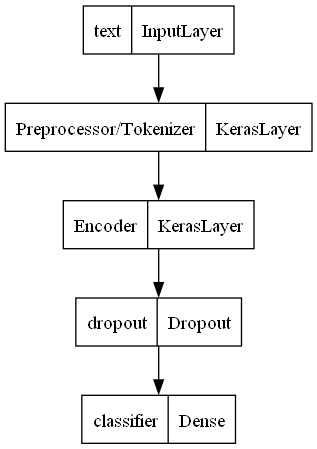

In [15]:
#text_test=['this is such an amazing movie!']
model = build_classifier_model(len(classdict))
tf.keras.utils.plot_model(model,'results/img/model.png')
#print(model.summary())
#bert_raw_result = model([tf.constant(text_test)])
#print(tf.sigmoid(bert_raw_result))

In [16]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
trs_time=time.process_time()
history=model.fit(train_ds['data'],validation_data=valid_ds['data'],verbose=1,epochs=CONFIG.EPOCHS)
tre_time=time.process_time()
train_time=tre_time-trs_time

Epoch 1/8
407/407 [==============================] - 294s 680ms/step - loss: 2.1459 - categorical_accuracy: 0.3608 - val_loss: 0.8845 - val_categorical_accuracy: 0.7187
Epoch 2/8
407/407 [==============================] - 275s 676ms/step - loss: 0.6088 - categorical_accuracy: 0.8174 - val_loss: 0.5575 - val_categorical_accuracy: 0.8185
Epoch 3/8
407/407 [==============================] - 276s 677ms/step - loss: 0.2998 - categorical_accuracy: 0.9099 - val_loss: 0.6353 - val_categorical_accuracy: 0.8459
Epoch 4/8
407/407 [==============================] - 275s 676ms/step - loss: 0.1322 - categorical_accuracy: 0.9608 - val_loss: 0.7874 - val_categorical_accuracy: 0.8439
Epoch 5/8
407/407 [==============================] - 276s 679ms/step - loss: 0.0585 - categorical_accuracy: 0.9836 - val_loss: 0.8575 - val_categorical_accuracy: 0.8600
Epoch 6/8
407/407 [==============================] - 277s 681ms/step - loss: 0.0170 - categorical_accuracy: 0.9951 - val_loss: 0.9464 - val_categorical_acc

In [17]:
#print(history.history)
model_name="{}_EP{}_BS{}_LR{}_ML{}".format(config.ENCODER_TYPE,config.EPOCHS,config.BATCH_SIZE,config.LEARNING_RATE,config.MAX_LENGTH)
model_name

'bert-large_EP8_BS16_LR3e-05_ML128'

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


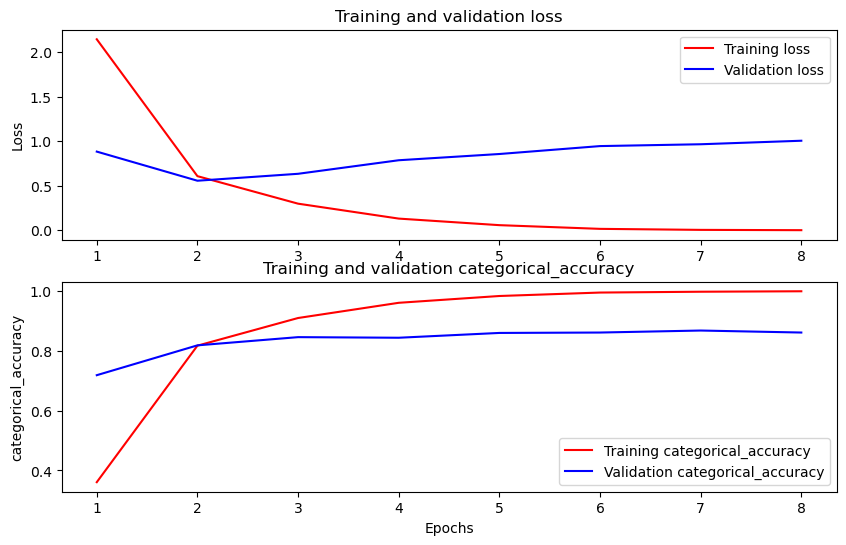

In [18]:
history_dict = history.history
print(history_dict.keys())

metrics_name=[m.name for m in metrics]

fig = plt.figure(figsize=(10, 3*(len(metrics_name)+1)))
fig.tight_layout()
epochs = range(1, config.EPOCHS + 1)

plt.subplot(len(metrics_name)+1, 1, 1)
# r is for "solid red line"
plt.plot(epochs, history_dict['loss'], 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

for i in range(0,len(metrics_name)):

    plt.subplot(len(metrics_name)+1, 1, i+2)
    plt.plot(epochs, history_dict[metrics_name[i]], 'r', label='Training {}'.format(metrics_name[i]))
    plt.plot(epochs, history_dict['val_{}'.format(metrics_name[i])], 'b', label='Validation {}'.format(metrics_name[i]))
    plt.title('Training and validation {}'.format(metrics_name[i]))
    plt.ylabel(metrics_name[i])
    plt.legend(loc='lower right')
    
plt.xlabel('Epochs')
plt.show()
plt.savefig('results/img/RE/{}_history.png'.format(model_name))
plt.close()

170/170 [==============================] - 30s 173ms/step


<AxesSubplot:>

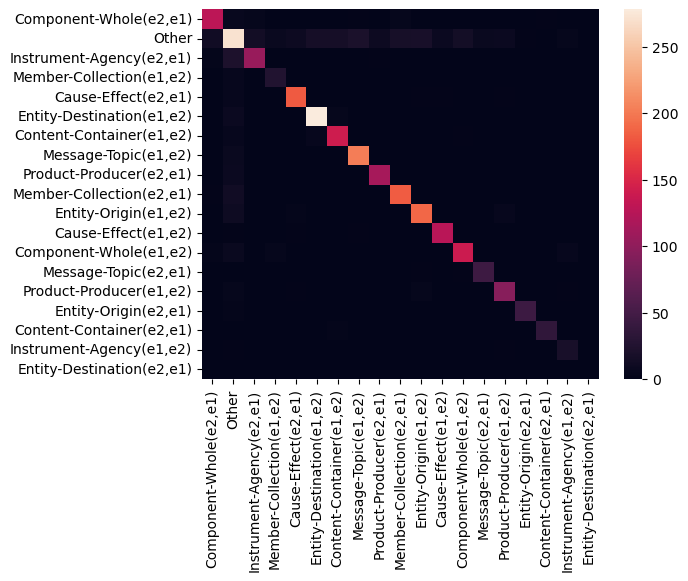

In [19]:
tss_time= time.process_time()
y_pred=model.predict(test_ds['X'],batch_size=CONFIG.BATCH_SIZE).argmax(axis=1)
tse_time= time.process_time()
test_time=tse_time-tss_time
y_true=test_ds['Y']
test_result=evaluation(y_true,y_pred)
test_result.setdefault('History',history.history)
test_result.setdefault('Time_cost',{'train':train_time,'test':test_time})
test_result.setdefault('Original',{'y_true':y_true,'y_pred':[int(x) for x in y_pred]})
#matrix=tf.math.confusion_matrix(y_true,y_pred).numpy()
sbn.heatmap(test_result['confusion_matrix'],xticklabels=invdict,yticklabels=invdict,annot=False)

In [20]:
metadata={'model_type':config.ENCODER_TYPE,
          'task_type':config.TASK,
          'epochs':config.EPOCHS,
          'learning_rate':config.LEARNING_RATE,
          'batch_size':config.BATCH_SIZE,
          'max_length':config.MAX_LENGTH,
          'model_name':model_name,
          'optimizer':optimizer._name,
          'metrics':[m.name for m in metrics],
          'loss':loss.name,
          'class_name':invdict,
          'is_saved':config.SAVE_MODEL,
          'devices':[gpu.name for gpu in GPUtil.getAvailable()],
          'structure':model.summary()
          }

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 Preprocessor/Tokenizer (KerasL  {'input_word_ids':   0          ['text[0][0]']                   
 ayer)                          (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [22]:
test_result

{'accuracy': 0.8557232241442768,
 'confusion_matrix': [[129,
   6,
   4,
   0,
   0,
   0,
   0,
   2,
   1,
   4,
   0,
   0,
   1,
   0,
   0,
   1,
   2,
   0,
   0],
  [12, 271, 14, 7, 9, 16, 16, 20, 9, 17, 18, 8, 15, 7, 8, 2, 1, 4, 0],
  [3, 21, 106, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
  [0, 5, 0, 24, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
  [0, 5, 1, 0, 182, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0],
  [0, 8, 0, 0, 0, 278, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  [0, 5, 0, 0, 0, 5, 141, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
  [0, 7, 0, 0, 0, 0, 0, 202, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 8, 0, 0, 0, 0, 0, 0, 115, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [2, 13, 0, 1, 0, 0, 0, 0, 1, 183, 0, 0, 0, 0, 0, 0, 0, 1, 0],
  [0, 10, 0, 1, 3, 1, 1, 0, 0, 0, 190, 0, 0, 0, 5, 0, 0, 0, 0],
  [0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 127, 0, 0, 0, 1, 0, 0, 0],
  [3, 7, 0, 4, 0, 1, 0, 1, 0, 1, 0, 0, 140, 0, 0, 0, 0, 5, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 45, 0, 0, 0, 0, 0],
  

In [21]:
if config.SAVE_MODEL:
    model.save('models/{}'.format(model_name))
saved_data={'Metadata':metadata,
            'Result':test_result}
with open('results/NRE_test_result.json','r',encoding='UTF-8')as f:
    s=json.load(f)
s.setdefault('task',config.TASK)
s.setdefault('Results',[])
s['Results'].append(saved_data)
with open('results/NRE_test_result.json','w',encoding='UTF-8')as f:
    json.dump(s,f,indent=2)